In [1]:
from google.colab import drive
drive.mount("/gdrive", force_remount=True)

Mounted at /gdrive


In [2]:
import os
print(os.getcwd())

# 작업 디렉토리 변경
os.chdir('/gdrive/MyDrive/tess2')
print(os.getcwd())

/content
/gdrive/MyDrive/tess2


In [8]:
import matplotlib.pyplot as plt
import os
import numpy as np
import torch
import sys

# 캐싱된 모듈 삭제
if 'models' in sys.modules:
    del sys.modules['models']
if 'Segdataset' in sys.modules:
    del sys.modules['Segdataset']
if 'utils' in sys.modules:
    del sys.modules['utils']

# 다시 임포트
from utils import plot_confusion_matrix, get_evaluation
from models import CNN , CNN_test
from Segdataset import SegDataset,read_test_file_list
from torch.utils.data import DataLoader

In [9]:
class Args:
    def __init__(self):
        self.data_root = '/gdrive/MyDrive/tess2/datasets/test'
        self.save_root = '/gdrive/MyDrive/tess2/checkpoints/CNN'
        self.random_seed = 10
        self.model_kind = 'cnn'
        self.num_workers = 8
        self.n_mfcc = 16
        self.n_folds = 5

opt = Args()


In [10]:
def main():
    emotions = ['NotStressed', 'Stressed']
    all_metrics = []

    for fold in range(opt.n_folds):
        if opt.model_kind == 'cnn':
            model = CNN_test()

        output_emotion_list = []
        label_emotion_list = []

        mfcc_list, emotion_list = read_test_file_list(root=opt.data_root, n_mfcc=opt.n_mfcc)
        test_set = SegDataset(mfcc_list, emotion_list)
        test_iter = DataLoader(test_set, batch_size=1, drop_last=True, num_workers=opt.num_workers)

        if torch.cuda.is_available():
            device = torch.device('cuda')
        elif torch.backends.mps.is_available():
            device = torch.device('mps')
        else:
            device = torch.device('cpu')

        model = model.to(device)

        # 모델 로드
        model.load_state_dict(torch.load(os.path.join(opt.save_root, f'fold_{fold + 1}_best_epoch.pth'), map_location=device))
        model.eval()

        with torch.no_grad():
            for index, (mfcc, emotion) in enumerate(test_iter):
                mfcc, emotion = mfcc.to(device), emotion.to(device)
                output_emotion = model(mfcc)
                output_emotion = torch.sigmoid(output_emotion)
                predicted_emotion = (output_emotion > 0.56).float()

                output_emotion_list.append(predicted_emotion.cpu().numpy())
                label_emotion_list.append(emotion.cpu().numpy())

        output_emotion_list = np.vstack(output_emotion_list)[:, 0]
        label_emotion_list = np.vstack(label_emotion_list)[:, 0]

        # 평가
        acc, precision, recall, f1 = get_evaluation(label_emotion_list, output_emotion_list)
        all_metrics.append((acc, precision, recall, f1))

        # 결과 출력
        print(f"Fold {fold + 1} - Accuracy: {acc}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

        # Confusion Matrix 생성 및 저장
        plt.figure()
        plot_confusion_matrix(label_emotion_list, output_emotion_list, emotions)
        plt.title(f'Confusion Matrix - Fold {fold + 1}')
        plt.savefig(os.path.join(opt.save_root, f'confusion_matrix_fold_{fold + 1}.png'))
        plt.show()

    # 평균값 계산
    avg_metrics = np.mean(all_metrics, axis=0)
    print(f"Average - Accuracy: {avg_metrics[0]}, Precision: {avg_metrics[1]}, Recall: {avg_metrics[2]}, F1 Score: {avg_metrics[3]}")


Dataset loaded with 560 samples.


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-10-a95019f605e7>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during un

(560,)
(560,)
(560,)
Fold 1 - Accuracy: 0.9821428571428571, Precision: 0.984, Recall: 0.984, F1 Score: 0.984


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

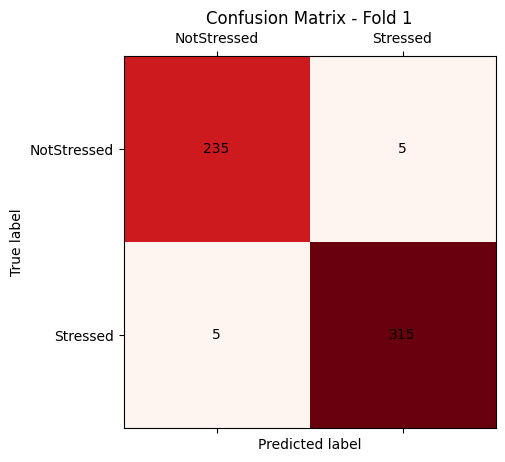

Dataset loaded with 560 samples.


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-10-a95019f605e7>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during un

(560,)
(560,)
(560,)
Fold 2 - Accuracy: 0.9589285714285715, Precision: 0.935, Recall: 0.997, F1 Score: 0.965


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

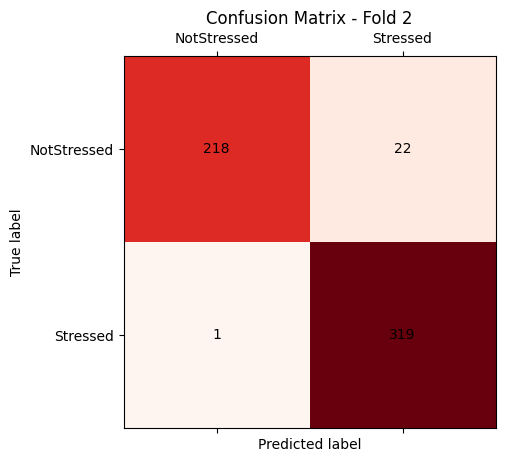

Dataset loaded with 560 samples.


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-10-a95019f605e7>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during un

(560,)
(560,)
(560,)
Fold 3 - Accuracy: 0.9714285714285714, Precision: 0.961, Recall: 0.991, F1 Score: 0.975


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

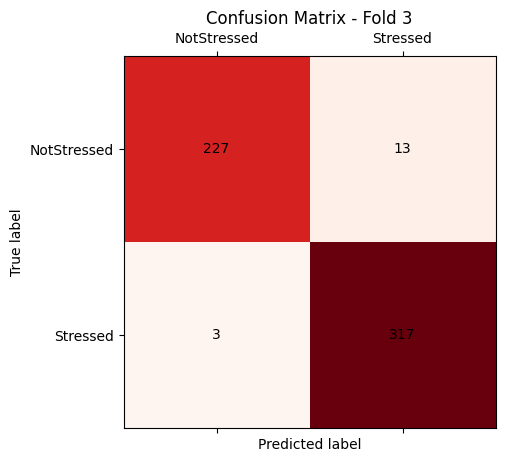

Dataset loaded with 560 samples.


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-10-a95019f605e7>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during un

(560,)
(560,)
(560,)
Fold 4 - Accuracy: 0.9678571428571429, Precision: 0.969, Recall: 0.975, F1 Score: 0.972


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

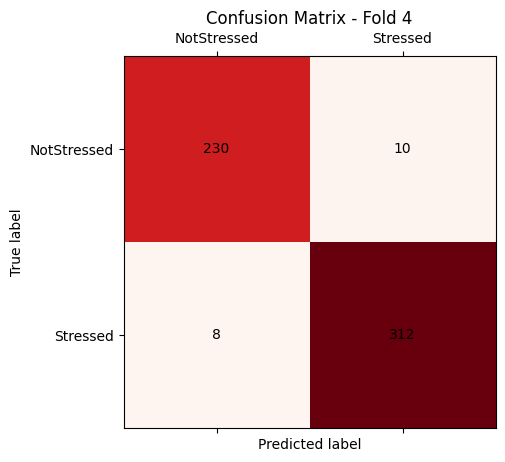

Dataset loaded with 560 samples.


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-10-a95019f605e7>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during un

(560,)
(560,)
(560,)
Fold 5 - Accuracy: 0.9642857142857143, Precision: 0.969, Recall: 0.969, F1 Score: 0.969


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

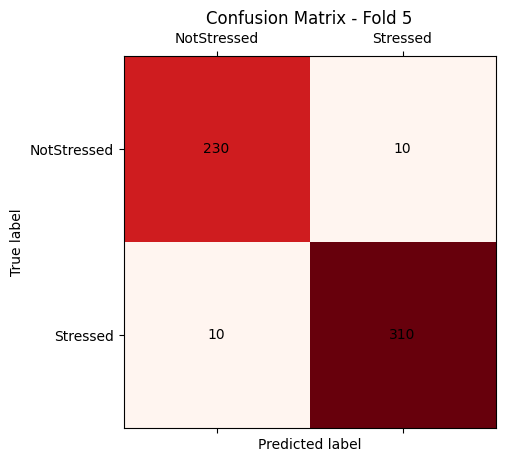

Average - Accuracy: 0.9689285714285715, Precision: 0.9635999999999999, Recall: 0.9832000000000001, F1 Score: 0.9730000000000001


In [11]:
if __name__ == '__main__':
    main()